Nutrient comparisons with edited dataset using surface instead of 2m for depth.

In [12]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools
import pytz
import os
%matplotlib inline

In [22]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [10]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [3]:
nutrients_2015 = pd.read_excel('/home/vdo/Downloads/PSFbottledata_CN_edits.xlsx')

In [4]:
nutrients_2015 = nutrients_2015.dropna(axis ='index', how = 'any')
datetimes = np.array([datetime.datetime.combine(pd.to_datetime(nutrients_2015['date'][index]),
                                      nutrients_2015['Time'][index]) 
                      for index in nutrients_2015.index])
nutrients_2015 = nutrients_2015.assign(datetime = datetimes)
local = pytz.timezone ("America/Los_Angeles")
utc_datetimes = np.array([local.localize(nutrients_2015['datetime'][index], 
                                         is_dst=None).astimezone(pytz.utc)
                          for index in nutrients_2015.index])
nutrients_2015 = nutrients_2015.assign(utc_datetime = utc_datetimes)
Yinds = np.array([])
Xinds = np.array([])
for n in nutrients_2015.index:
    Yind, Xind = geo_tools.find_closest_model_point(nutrients_2015['lon'][n], 
                                                    nutrients_2015['lat'][n], 
                                                    X, Y, land_mask = bathy.mask)
    Yinds = np.append(Yinds, Yind)
    Xinds = np.append(Xinds, Xind)
nutrients_2015 = nutrients_2015.assign(Yind = Yinds)
nutrients_2015 = nutrients_2015.assign(Xind = Xinds)
nutrients_2015 = nutrients_2015.dropna(axis ='index', how = 'any')

In [5]:
nutrients_2015.shape

(818, 14)

In [9]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [14]:
list_of_model_si = np.ma.masked_array(np.zeros((818)), mask = True)
list_of_model_ni = np.ma.masked_array(np.zeros((818)), mask = True)
t = 0
for n in nutrients_2015.index:
    Yind = int(nutrients_2015['Yind'][n])
    Xind = int(nutrients_2015['Xind'][n])
    date = pd.to_datetime(nutrients_2015['utc_datetime'][n])
    sub_dir = date.strftime('%d%b%y').lower()
    datestr = date.strftime('%Y%m%d')
    fname = 'SalishSea_1d_{}_{}_ptrc_T.nc'.format(datestr, datestr)
    nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
    
    if ((nutrients_2015['depth'][n] == 20) and (mesh.variables['tmask'][0,18,Yind,Xind] == 1)):
        si_val = nuts.variables['silicon'][0, 18, Yind, Xind]
        ni_val = nuts.variables['nitrate'][0, 18, Yind, Xind]
        list_of_model_si.mask[t] = False
        list_of_model_si[t] = si_val
        list_of_model_ni.mask[t] = False
        list_of_model_ni[t] = ni_val
    elif ((nutrients_2015['depth'][n] == 2) and (mesh.variables['tmask'][0,0,Yind,Xind] == 1)):
        si_val = nuts.variables['silicon'][0, 0, Yind, Xind]
        ni_val = nuts.variables['nitrate'][0, 0, Yind, Xind]
        list_of_model_si.mask[t] = False
        list_of_model_si[t] = si_val
        list_of_model_ni.mask[t] = False
        list_of_model_ni[t] = ni_val
    t = t + 1

In [15]:
cs_ni = np.ma.masked_array(nutrients_2015['no23'].values, mask = list_of_model_ni.mask)
cs_si = np.ma.masked_array(nutrients_2015['si'].values, mask = list_of_model_si.mask)

In [16]:
np.ma.count(cs_ni)

807

bias =  -1.82591113752
RMSE = 6.76204678111
Willmott = 0.858734805816


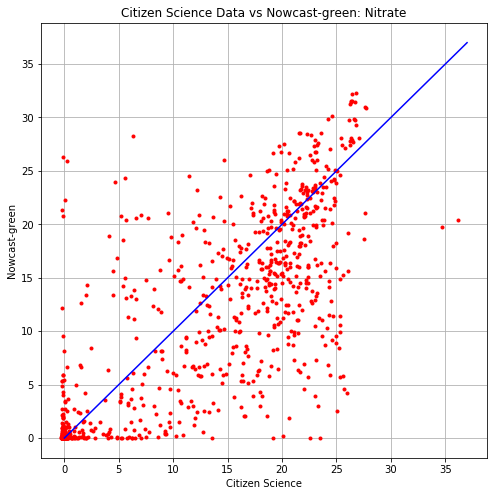

In [18]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_ni, list_of_model_ni, 'r.')
ax.plot(np.arange(0,38), np.arange(0,38), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Nitrate')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_ni) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - cs_ni)**2) /
                              807)))
xbar = np.mean(cs_ni)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - cs_ni)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(cs_ni - xbar))**2))))

bias =  -10.4146409372
RMSE = 17.0773725613
Willmott = 0.714232688239


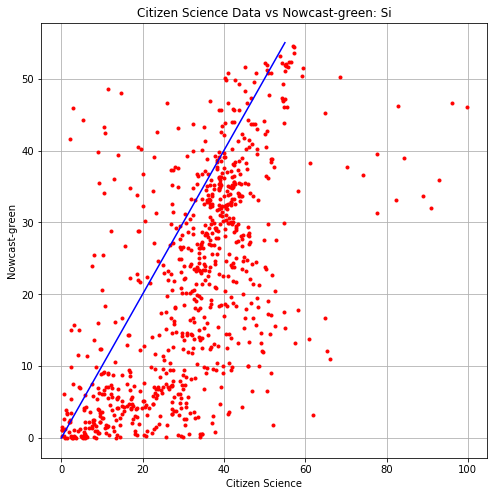

In [20]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_si, list_of_model_si, 'r.')
ax.plot(np.arange(0,56), np.arange(0,56), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Si')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - cs_si)**2) /
                              807)))
xbar = np.mean(cs_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - cs_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(cs_si - xbar))**2))))

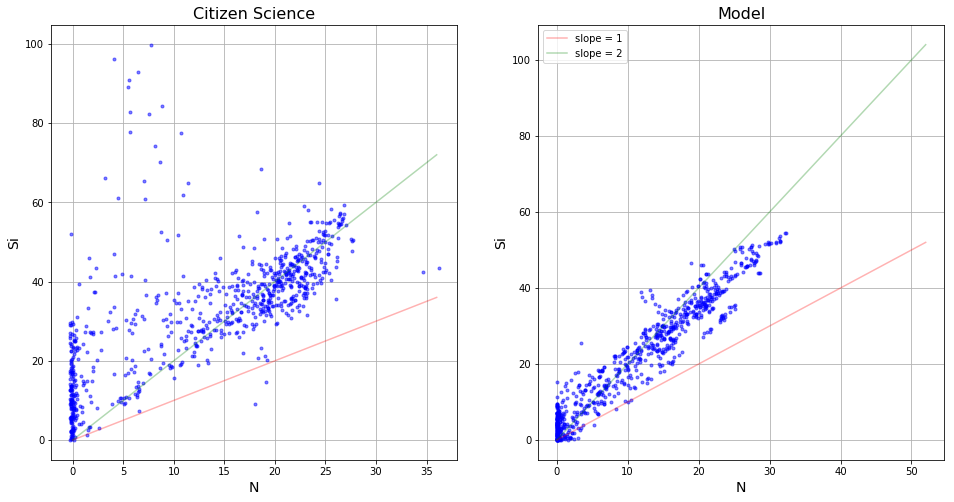

In [21]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].plot(cs_ni, cs_si, 'b.', alpha = 0.5)
x = np.arange(0,37)
ax[0].plot(x,x, 'r-', alpha = 0.3)
ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[1].plot(list_of_model_ni, list_of_model_si, 'b.', alpha = 0.5)
x = np.arange(0,53)
ax[1].plot(x,x, 'r-', alpha = 0.3, label = 'slope = 1')
ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
plt.legend();

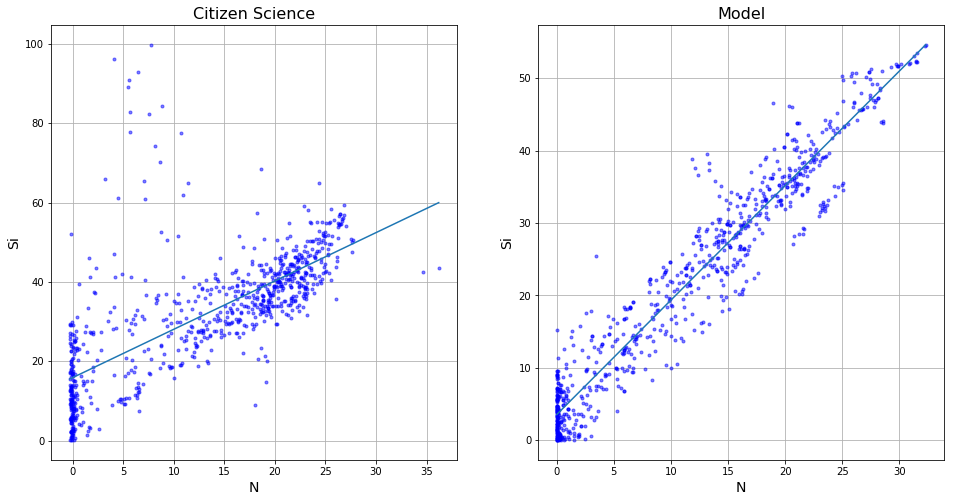

In [24]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].plot(cs_ni, cs_si, 'b.', alpha = 0.5)
ax[0].plot(np.unique(cs_ni), np.poly1d(np.polyfit(cs_ni, cs_si, 1))(np.unique(cs_ni)))
x = np.arange(0,37)
#ax[0].plot(x,x, 'r-', alpha = 0.3)
#ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[1].plot(list_of_model_ni, list_of_model_si, 'b.', alpha = 0.5)
ax[1].plot(np.unique(list_of_model_ni), 
           np.poly1d(np.polyfit(list_of_model_ni, list_of_model_si, 1))(np.unique(list_of_model_ni)))
x = np.arange(0,53)
#ax[1].plot(x,x, 'r-', alpha = 0.3, label = 'slope = 1')
#ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
#plt.legend();

In [25]:
m1, b1 = np.polyfit(cs_ni, cs_si, 1)
print('CitSci slope = ' + str(m1))
print('CitSci y int = ' + str(b1))
m2, b2 = np.polyfit(list_of_model_ni, list_of_model_si, 1)
print('model slope = ' + str(m2))
print('model y int = ' + str(b2))

CitSci slope = 1.21836179468
CitSci y int = 15.8608155123
model slope = 1.58186078069
model y int = 3.52970004613
